In [27]:
import scanpy as sc
import leidenalg
import tsKNEE
import os
import subprocess

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
path_to_memusg = os.path.join(parent_dir, 'memusg', 'memusg')
os.chmod(path_to_memusg, 0o755)
os.environ['PATH'] += os.pathsep + os.path.dirname(path_to_memusg)

def run_memusg(command):
    result = subprocess.run([path_to_memusg] + command.split(), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    if result.returncode != 0:
        print(f"Return code: {result.returncode}")
        raise RuntimeError(f"Command failed with return code {result.returncode}")
    return result.stdout

In [28]:
adata = sc.read_h5ad("../small_test_data/small_test_data1.h5ad")

sc.pp.neighbors(adata, use_rep='X')
sc.tl.leiden(adata)

adata_file = 'adata.h5ad'
adata.write(adata_file)

In [29]:
print('# Compute Benchmark of Clustering')
print('tSNE')
%time sc.tl.tsne(adata)
print('tsKNEE')
%time x = tsKNEE.tsKNEE(adata)

# Compute Benchmark of Clustering
tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 3.31 s, sys: 64 ms, total: 3.38 s
Wall time: 458 ms
tsKNEE
CPU times: user 861 ms, sys: 4.09 ms, total: 865 ms
Wall time: 865 ms


# Compute Benchmark of Plotting
tSNE


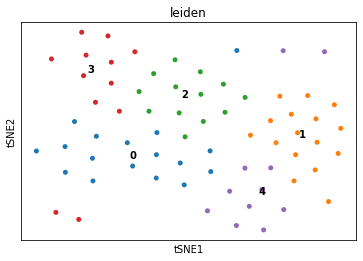

CPU times: user 60.4 ms, sys: 24.1 ms, total: 84.5 ms
Wall time: 81.3 ms
tsKNEE


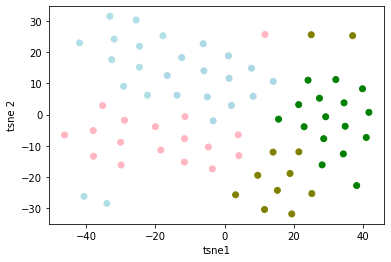

CPU times: user 94.5 ms, sys: 4.07 ms, total: 98.5 ms
Wall time: 97.2 ms


In [30]:
print('# Compute Benchmark of Plotting')
print('tSNE')
%time sc.pl.tsne(adata, color=['leiden'], legend_loc='on data', legend_fontsize=10, size=100)
print('tsKNEE')
%time tsKNEE.tsKNEE_plot(adata)

In [31]:
print('# Memory Benchmark of Clustering')

print('tSNE')
tsne_memusg_output = run_memusg(f'python -c "import scanpy as sc; adata = sc.read(\'{adata_file}\'); sc.tl.tsne(adata)"')
print(tsne_memusg_output)

print('tsKNEE')
tsknee_memusg_output = run_memusg(f'python -c "import scanpy as sc; from tsKNEE import tsKNEE; adata = sc.read(\'{adata_file}\'); tsKNEE(adata)"')
print(tsknee_memusg_output)

# Memory Benchmark of Clustering
tSNE

         Falling back to preprocessing with `sc.pp.pca` and default params.
memusg: vmpeak: 18803564 kb


tsKNEE

memusg: vmpeak: 18140680 kb




In [32]:
print('# Memory Benchmark of Plotting')

print('tSNE')
tsne_memusg_output = run_memusg(f'python -c "import scanpy as sc; adata = sc.read(\'{adata_file}\'); sc.tl.tsne(adata); sc.pl.tsne(adata, color=[\'leiden\'], legend_loc=\'on data\', legend_fontsize=10, size=100)"')
print(tsne_memusg_output)

print('tsKNEE')
tsknee_memusg_output = run_memusg(f'python -c "import scanpy as sc; from tsKNEE import tsKNEE_plot; adata = sc.read(\'{adata_file}\'); tsKNEE_plot(adata)"')
print(tsknee_memusg_output)

# Memory Benchmark of Plotting
tSNE
Figure(640x480)

         Falling back to preprocessing with `sc.pp.pca` and default params.
memusg: vmpeak: 18804344 kb

Figure(640x480)

tsKNEE

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/jlyoung/CSE185_Proj/tsKNEE/tsKNEE.py", line 104, in tsKNEE_plot
    raise Exception("Run tsKNEE on anndata object before continuing")
Exception: Run tsKNEE on anndata object before continuing
memusg: vmpeak: 18140684 kb

Return code: 1


RuntimeError: Command failed with return code 1

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

def continuity_score(X_high, X_low, n_neighbors=5):
    """
    Compute the continuity score of the low-dimensional embedding.

    Parameters:
    X_high : array-like, shape (n_samples, n_features)
        High-dimensional data.
    X_low : array-like, shape (n_samples, n_components)
        Low-dimensional embedding.
    n_neighbors : int, optional, default: 5
        Number of nearest neighbors to consider.

    Returns:
    continuity : float
        Continuity score.
    """
    n_samples = X_high.shape[0]

    # Find nearest neighbors in high-dimensional space
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_high)
    distances_high, indices_high = nbrs_high.kneighbors(X_high)

    # Find nearest neighbors in low-dimensional space
    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_low)
    distances_low, indices_low = nbrs_low.kneighbors(X_low)

    # Remove self-indices (first column)
    indices_high = indices_high[:, 1:]
    indices_low = indices_low[:, 1:]

    # Compute continuity score
    continuity = 0
    for i in range(n_samples):
        intersection = len(set(indices_high[i]).intersection(set(indices_low[i])))
        continuity += intersection / n_neighbors

    continuity /= n_samples
    return continuity

In [10]:
# Load data
my_adata = sc.read_h5ad("../small_test_data/small_test_data1.h5ad")
sc.pp.neighbors(my_adata)
sc.tl.leiden(my_adata)    

tsne_adata = sc.read_h5ad("../small_test_data/small_test_data1.h5ad")
sc.pp.neighbors(tsne_adata)
sc.tl.leiden(tsne_adata) 

# Compute t-SNE
sc.tl.tsne(tsne_adata)
tsKNEE.tsKNEE(my_adata)

# Calculate continuity
my_continuity = continuity_score(my_adata.X, my_adata.obsm['X_tsne'], n_neighbors=5)
print(f"tsKNEE continuity: {my_continuity}")

tsne_continuity = continuity_score(tsne_adata.X, tsne_adata.obsm['X_tsne'], n_neighbors=5)
print(f"tsne continuity: {tsne_continuity}")

         Falling back to preprocessing with `sc.pp.pca` and default params.


         Falling back to preprocessing with `sc.pp.pca` and default params.
tsKNEE continuity: 0.6057971014492755
tsne continuity: 0.2840579710144926
